In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path
import xarray as xr

from helpers.delphi_epidata import Epidata
import epiweeks

## Dataset format for my class:
The dataset is a xarray object stored as netcdf on disk. It has dimensions `(sample, feature, date, place)` where date and place are padded to have dimension 64.
- dates are Saturdays
- places are location from Flusight data locations
- samples are integers

```python
import torchvision.transforms.functional as TF
import random

def my_segmentation_transforms(image, segmentation):
    if random.random() > 0.5:
        angle = random.randint(-30, 30)
        image = TF.rotate(image, angle)
        segmentation = TF.rotate(segmentation, angle)
    # more transforms ...
    return image, segmentation
```

In [ ]:
flu_season_start_date = pd.to_datetime("2020-12-15")

## FluSight dataset (= Ground-truth data)

Make sure my fork is synced, then
```bash
./update_data.sh
```
Locations are always ordered like this dataframe:

In [29]:
flusight_locations = pd.read_csv("datasets/Flusight-forecast-data/data-locations/locations.csv")
flusight_locations['geoid'] = flusight_locations['location']+'000'
flusight_locations = flusight_locations.iloc[1:,:].reset_index(drop=True)  # skip first row, which is the US full
flusight_locations['location_code'] = flusight_locations['location']       # "location" collides with datasets column name
flusight_locations.drop(columns=['location'], inplace=True)

In [30]:
def get_location_name(location_code):
    return flusight_locations[flusight_locations['location_code']==location_code]['location_name'].values[0]

In [31]:
hosp = pd.read_csv("datasets/Flusight-forecast-data/data-truth/truth-Incident Hospitalizations.csv", parse_dates=True, index_col='date')
hosp = hosp[hosp['location'].isin(flusight_locations['location_code'])]

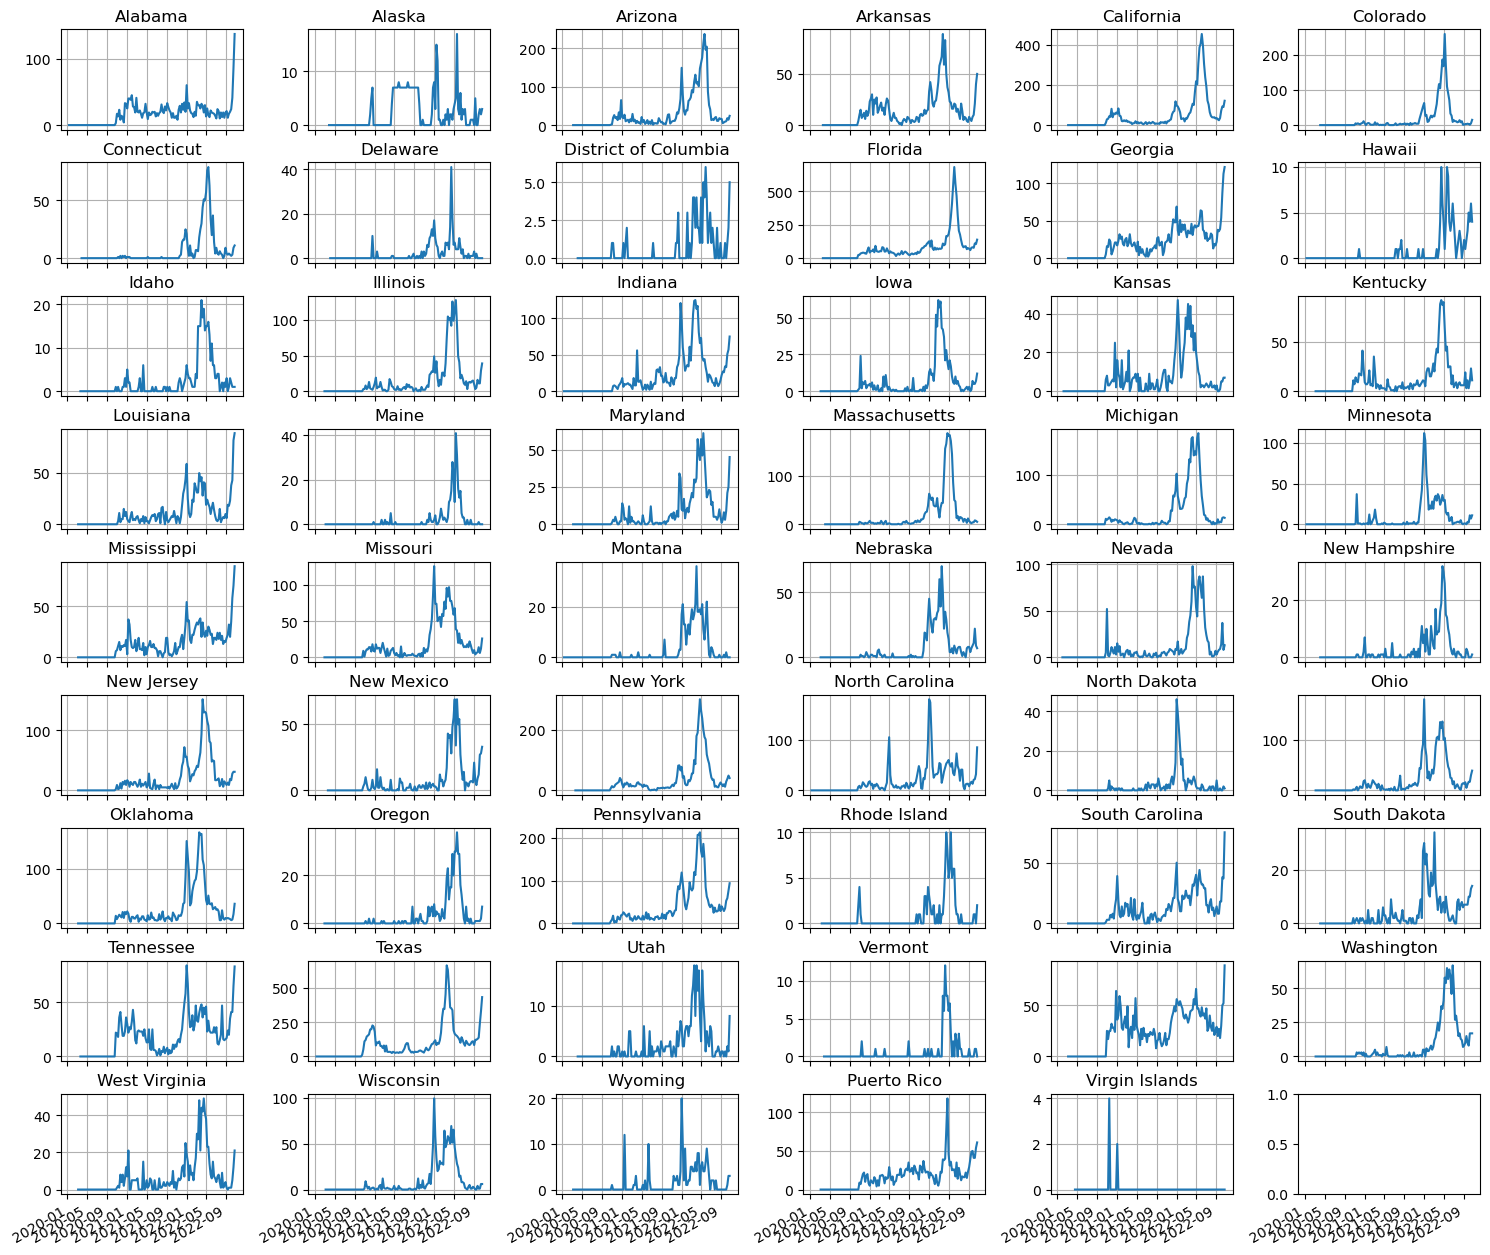

In [32]:
fig, axes = plt.subplots(9, 6, sharex=True, figsize=(15,15))
hosp_piv  = hosp.pivot(columns='location', values='value')
for idx, pl in enumerate(flusight_locations["location_code"]):
    ax = axes.flat[idx]
    ax.plot(hosp_piv[pl])
    ax.set_title(get_location_name(pl))
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

In [33]:
assert (hosp_piv.columns == flusight_locations['location_code']).all() # make sure order is right

In [34]:
np.array([hosp_piv.to_numpy()]).shape

(1, 146, 53)

In [35]:
gt_xarr = xr.DataArray(np.array([hosp_piv.to_numpy()]),
            name = "gt_flusight_incidHosp",
            coords={'feature': ["incidHosp"], 'date': hosp_piv.index, 'place': flusight_locations['location_code']}, 
            dims=["feature", "date", "place"])

print(gt_xarr.shape)
gt_xarr.to_netcdf(f"datasets/{gt_xarr.name}.nc")

(1, 146, 53)


This data is on saturday for 53 locations + US

In [36]:
download=False

## Delphi-epidata Flusurv

In [41]:
def get_all_locations(dataset):
    if dataset == "flusurv":
        locations_fn = "datasets/delphi-epidata/labels/flusurv_locations.txt"
        locations = pd.read_csv(locations_fn, sep='\t', header=None, names=['location'])["location"].to_list()
    elif dataset=="fluview":
        import importlib  
        fluview_locations_m = importlib.import_module("datasets.delphi-epidata.src.acquisition.fluview.fluview_locations")
        fll_dict = fluview_locations_m.cdc_to_delphi
        locations = []
        for region_type in fll_dict.keys():
            for region_name, flloc in fll_dict[region_type].items():
                locations.append(flloc)
    return locations



def get_fluseason_year(ts):
    if ts.dayofyear >= flu_season_start_date.dayofyear:
        return ts.year 
    else:
        return ts.year - 1

def get_fluseason_fraction(ts):
    if ts.dayofyear >= flu_season_start_date.dayofyear:
        return (ts.dayofyear - flu_season_start_date.dayofyear) / 365
    else:
        return ((ts.dayofyear + 365) - flu_season_start_date.dayofyear)  / 365




def get_from_epidata(dataset, locations="all", write=True, download=True):
    if download:
        # by location otherwise queries is too big
        df_list = []
        if locations == "all":
            locations = get_all_locations(dataset=dataset)

        for location in locations:
            if dataset == 'flusurv':
                res = Epidata.flusurv(location, [Epidata.range(190001, 202251)])  # large range to get all data
            elif dataset == "fluview":
                res = Epidata.fluview(location, [Epidata.range(190001, 202251)])  # large range to get all data
            if res['result'] == 1:
                flu_data_loc = pd.json_normalize(res['epidata'])
                print(f">> {location: <12} {res['result']}, {res['message']}, with {len(res['epidata']):4} data points from {flu_data_loc.epiweek.min()} to {flu_data_loc.epiweek.max()}")
                df_list.append(flu_data_loc)
            else:
                print(f"EE {location: <12} {res['result']}, {res['message']} !")
        
        df = pd.concat(df_list)
        df['week_enddate'] = df['epiweek'].astype(str).apply(lambda x: epiweeks.Week.fromstring(week_string=x, system="cdc").enddate())


    else:
        df = pd.read_csv(f"datasets/{dataset}.csv")

    df['week_enddate'] = pd.to_datetime(df['week_enddate'])

    if write:  # write before merge
        df.to_csv(f"datasets/{dataset}.csv", index=False)
    
    # merge with locations, taking care of new york
    if dataset == "flusurv": 
        df["location_tomerge"] = df["location"]
        df["location_tomerge"] = df["location_tomerge"].str.replace("NY_albany", "NY")
        df["location_tomerge"] = df["location_tomerge"].str.replace("NY_rochester", "NY")
    elif dataset == "fluview": 
        df["location_tomerge"] = df['region'].str.upper()
        df["location_tomerge"] = df["location_tomerge"].str.replace("jfk", "NY")
        df["location_tomerge"] = df["location_tomerge"].str.replace("ny_minus_jfk", "NY")
    df = pd.merge(df, flusight_locations, left_on="location_tomerge", right_on='abbreviation', how='left')
    df.drop(columns=['location_tomerge'], inplace=True)

    # get the flu season year and it's fraction elapsed
    df["fluseason"]= df["week_enddate"].apply(get_fluseason_year)
    df["fluseason_fraction"]= df["week_enddate"].apply(get_fluseason_fraction)

    return df


In [50]:
flusurv = get_from_epidata(dataset="flusurv", download=download)
flusurv.columns

Index(['release_date', 'location', 'issue', 'epiweek', 'lag', 'rate_age_0',
       'rate_age_1', 'rate_age_2', 'rate_age_3', 'rate_age_4', 'rate_overall',
       'week_enddate', 'abbreviation', 'location_name', 'population', 'geoid',
       'location_code', 'fluseason', 'fluseason_fraction'],
      dtype='object')

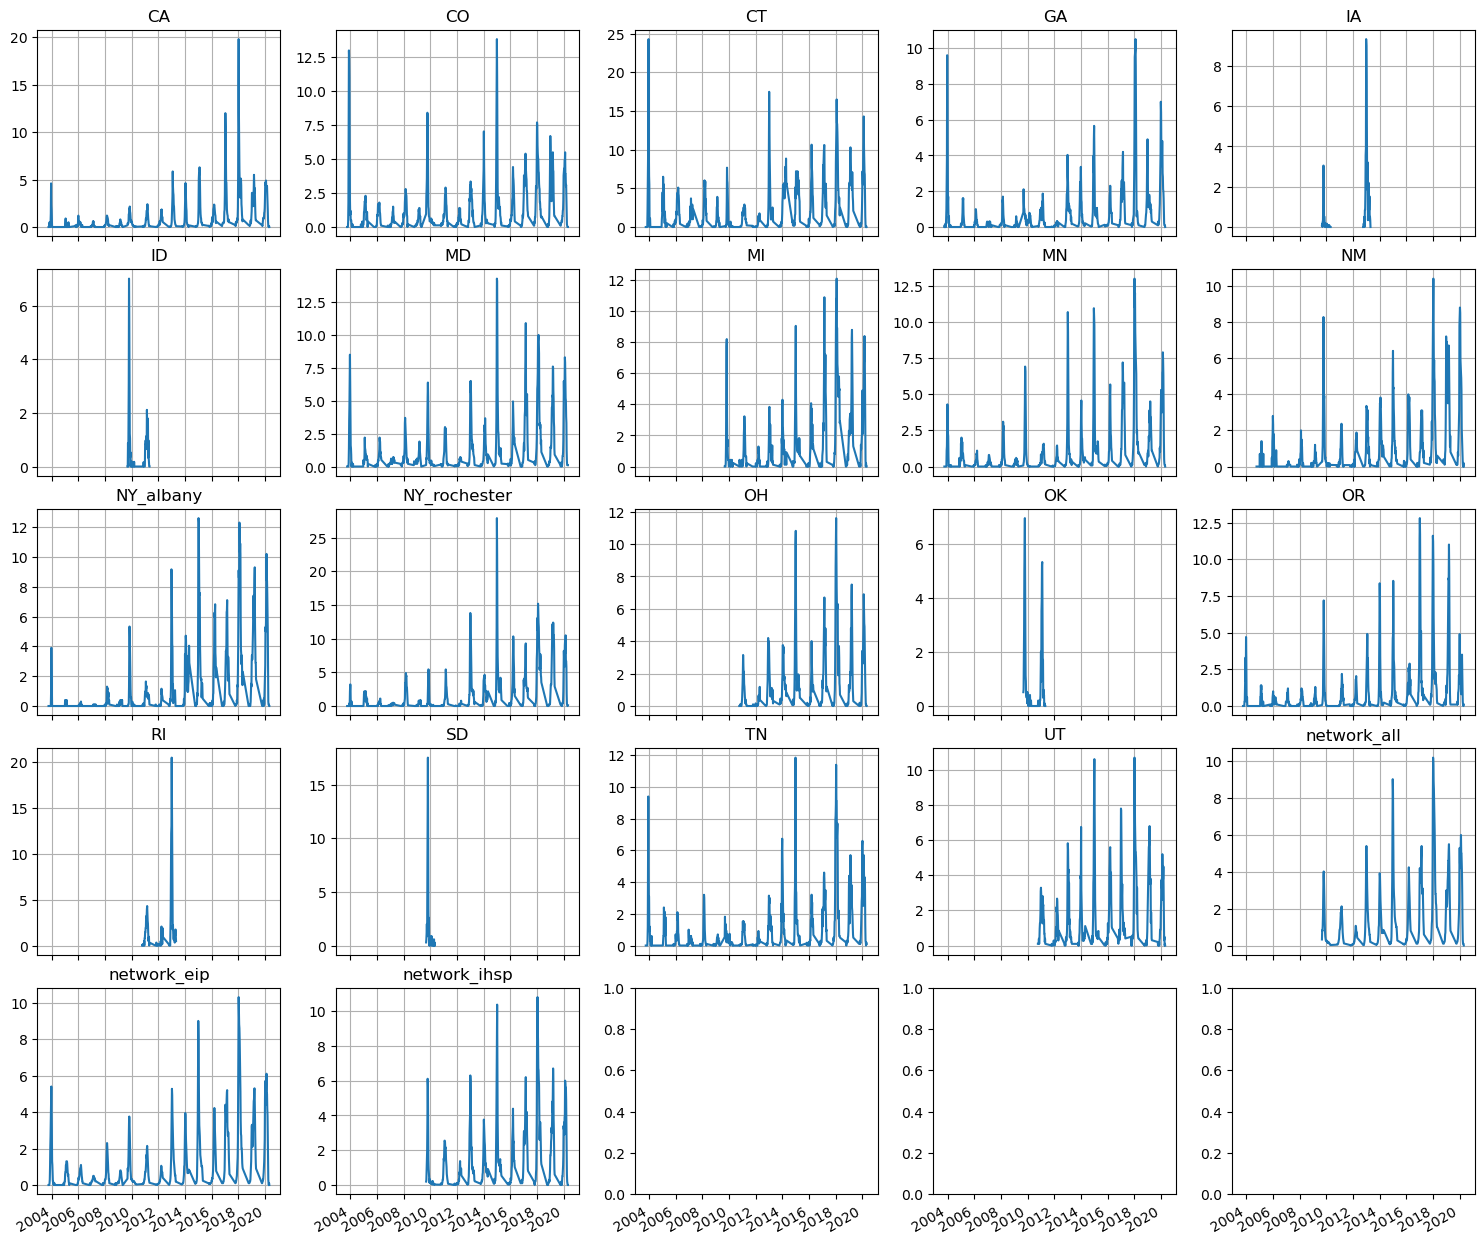

In [43]:
fig, axes = plt.subplots(5, 5, sharex=True, figsize=(15,15))
flusurv_piv  = flusurv.pivot(columns='location', values='rate_overall', index="week_enddate")
for idx, pl in enumerate(get_all_locations("flusurv")):
    ax = axes.flat[idx]
    ax.plot(flusurv_piv[pl])
    ax.set_title(pl)#get_location_name(pl))
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

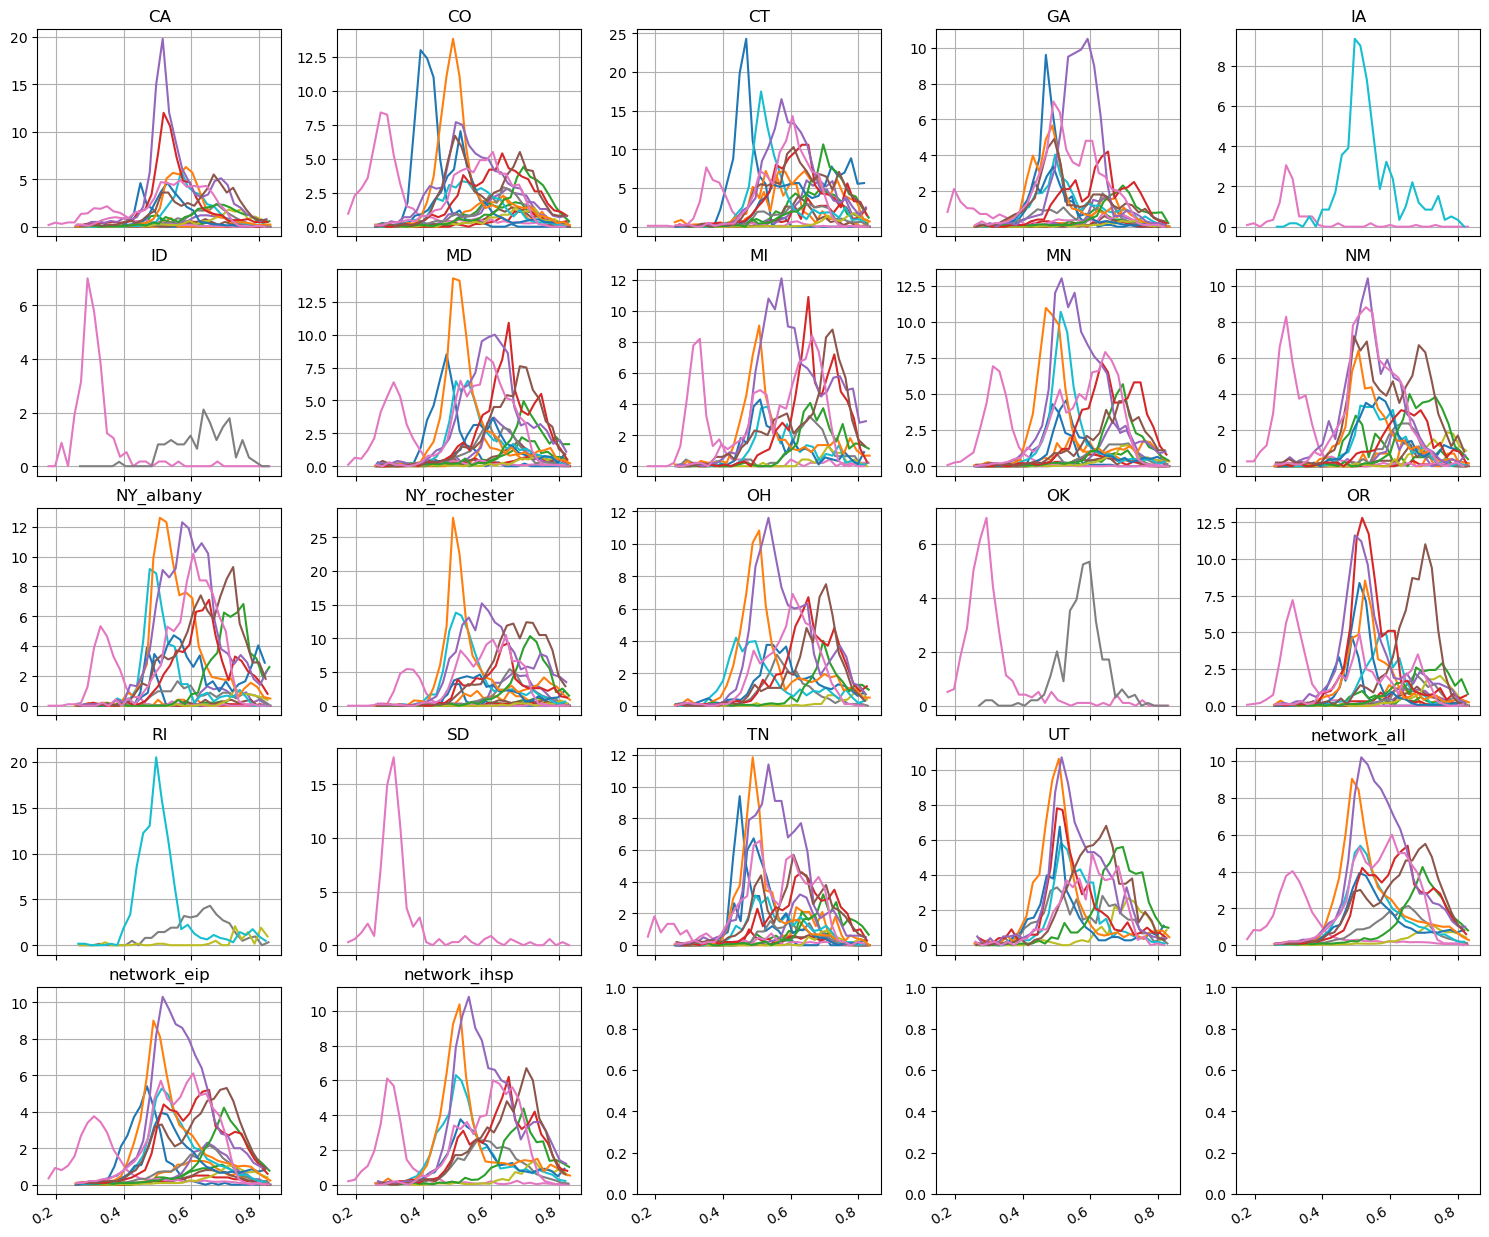

In [44]:
fig, axes = plt.subplots(5, 5, sharex=True, figsize=(15,15))
flusurv_piv = flusurv.pivot(columns='location', values='rate_overall', index=["fluseason", "fluseason_fraction"])
for idx, pl in enumerate(get_all_locations("flusurv")):
    for year in flusurv_piv.index.unique(level='fluseason'):
        ax = axes.flat[idx]
        ax.plot(flusurv_piv.loc[year, pl])
        ax.set_title(pl)
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

## Epidata Fluview
There is also [fluview clinical](https://cmu-delphi.github.io/delphi-epidata/api/fluview_clinical.html) for FluA, FluB, and tested specimen. Which quantity should I look for in this dataset ?

In [45]:
fluview = get_from_epidata(dataset="fluview", download=download)
fluview

,release_date,region,issue,epiweek,lag,num_ili,num_patients,num_providers,num_age_0,num_age_1,...,wili,ili,week_enddate,abbreviation,location_name,population,geoid,location_code,fluseason,fluseason_fraction
0,2013-12-31,nat,201352,199740,847,570,46842,192,179.0,205.0,...,1.101483,1.216857,1997-10-04,NaN,NaN,NaN,NaN,NaN,1997,0.257534
1,2013-12-31,nat,201352,199741,846,615,48023,191,199.0,242.0,...,1.200068,1.280636,1997-10-11,NaN,NaN,NaN,NaN,NaN,1997,0.276712
2,2013-12-31,nat,201352,199742,845,681,54961,219,228.0,266.0,...,1.378763,1.239060,1997-10-18,NaN,NaN,NaN,NaN,NaN,1997,0.295890
3,2013-12-31,nat,201352,199743,844,653,57044,213,188.0,236.0,...,1.199199,1.144730,1997-10-25,NaN,NaN,NaN,NaN,NaN,1997,0.315068
4,2013-12-31,nat,201352,199744,843,700,55506,213,217.0,280.0,...,1.656178,1.261125,1997-11-01,NaN,NaN,NaN,NaN,NaN,1997,0.334247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56398,2022-09-09,jfk,202235,202231,4,1517,79616,26,NaN,NaN,...,1.905400,1.905400,2022-08-06,NaN,NaN,NaN,NaN,NaN,2022,0.095890
56399,2022-09-09,jfk,202235,202232,3,1377,78674,26,NaN,NaN,...,1.750260,1.750260,2022-08-13,NaN,NaN,NaN,NaN,NaN,2022,0.115068
56400,2022-09-09,jfk,202235,202233,2,1384,76378,25,NaN,NaN,...,1.812040,1.812040,2022-08-20,NaN,NaN,NaN,NaN,NaN,2022,0.134247
56401,2022-09-09,jfk,202235,202234,1,1227,76349,24,NaN,NaN,...,1.607090,1.607090,2022-08-27,NaN,NaN,NaN,NaN,NaN,2022,0.153425


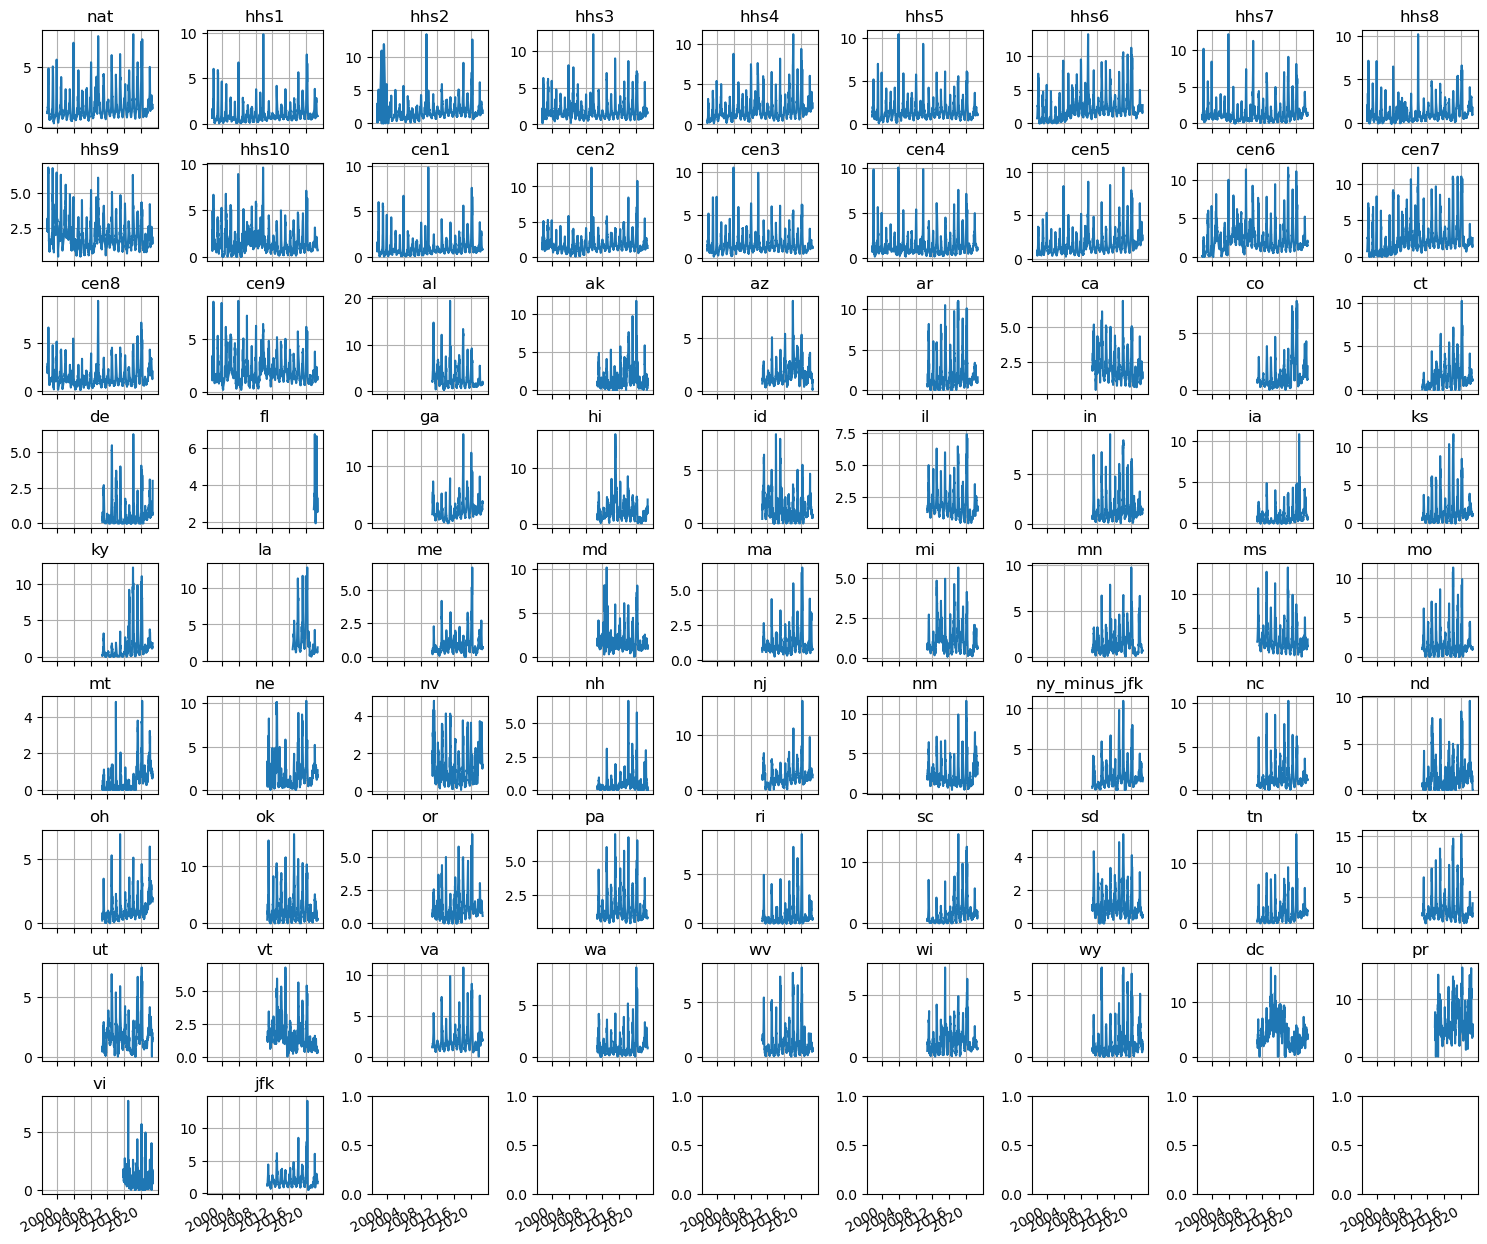

In [46]:
fig, axes = plt.subplots(9, 9, sharex=True, figsize=(15,15))

fluview_piv  = fluview.pivot(columns='region', values='ili', index="week_enddate")
for idx, pl in enumerate(fluview["region"].unique()):
    ax = axes.flat[idx]
    ax.plot(fluview_piv[pl])
    ax.set_title(pl)#get_location_name(pl))
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

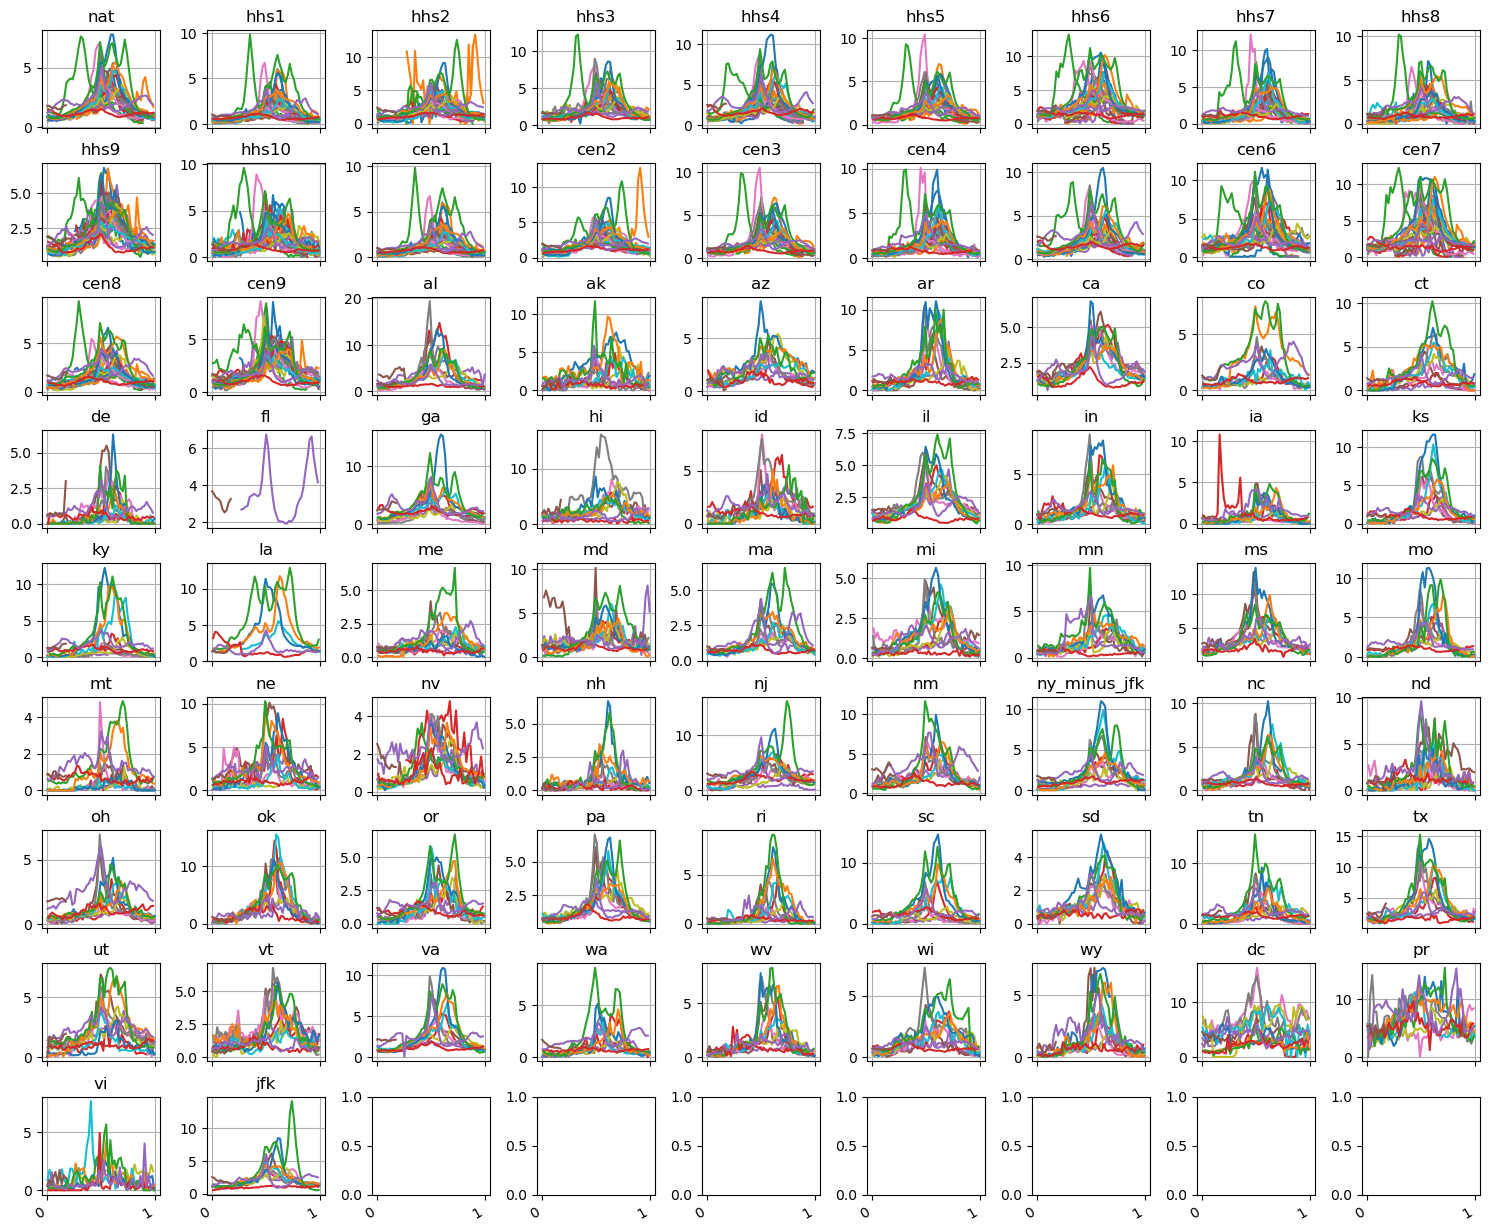

In [47]:
fig, axes = plt.subplots(9, 9, sharex=True, figsize=(15,15))
fluview_piv = fluview.pivot(columns='region', values='ili', index=["fluseason", "fluseason_fraction"])
for idx, pl in enumerate(fluview["region"].unique()):
    for year in fluview_piv.index.unique(level='fluseason'):
        ax = axes.flat[idx]
        ax.plot(fluview_piv.loc[year, pl])
        ax.set_title(pl)
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

## Merge datasets

In [48]:
for locations_code in flusight_locations.location_code:
    in_fluview, in_flusruv = False, False
    if not flusurv[flusurv['location_code'] == locations_code].empty:
        in_flusruv = True
    if not fluview[fluview['location_code'] == locations_code].empty:
        in_fluview = True
    if in_fluview and in_flusruv:
        print(f"{locations_code}, {get_location_name(locations_code):<22} in both fluview and flusurv")
    elif in_fluview:
        print(f"{locations_code}, {get_location_name(locations_code):<22} in fluview")
    elif in_flusruv:
        print(f"{locations_code}, {get_location_name(locations_code):<22} in flusurv")
    else:
        print(f"{locations_code}, {get_location_name(locations_code):<22} NOT in fluview NOR flusurv")

01, Alabama                in fluview
02, Alaska                 in fluview
04, Arizona                in fluview
05, Arkansas               in fluview
06, California             in both fluview and flusurv
08, Colorado               in both fluview and flusurv
09, Connecticut            in both fluview and flusurv
10, Delaware               in fluview
11, District of Columbia   in fluview
12, Florida                in fluview
13, Georgia                in both fluview and flusurv
15, Hawaii                 in fluview
16, Idaho                  in both fluview and flusurv
17, Illinois               in fluview
18, Indiana                in fluview
19, Iowa                   in both fluview and flusurv
20, Kansas                 in fluview
21, Kentucky               in fluview
22, Louisiana              in fluview
23, Maine                  in fluview
24, Maryland               in both fluview and flusurv
25, Massachusetts          in fluview
26, Michigan               in both fluview an

In [ ]:
# let's write only fluview for now


## Synthetic dataset from CSP

In [ ]:
assert False  # stop here when "Run All" is used in this notebook
import gempyor
folder = 'datasets/SMH_R1/'
col2keep = ['incidH_FluA', 'incidH_FluB']

Commands to sync Flu SMH R1 from s3 bucket
```bash
aws s3 sync s3://idd-inference-runs/USA-20220923T154311/model_output/ datasets/SMH_R1/SMH_R1_lowVac_optImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T155228/model_output/ datasets/SMH_R1/SMH_R1_lowVac_pesImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T160106/model_output/ datasets/SMH_R1/SMH_R1_highVac_optImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T161418/model_output/ datasets/SMH_R1/SMH_R1_highVac_pesImm_2022 --exclude "*" --include "hosp*/final/*"
```
and take a humidity file from the config


In [ ]:
humid = pd.read_csv('datasets/SMH_R1/SMH_R1_lowVac_optImm_2022/r0s_ts_2022-2023.csv', index_col='date', parse_dates=True)

In [ ]:
maxfiles = -1
hosp_files = list(Path(str(folder)).rglob('*.parquet'))[:maxfiles]
df = gempyor.read_df(str(hosp_files[0]))

# To be pasted later
indexes = df[['date', 'geoid']]
full_df = df[['date', 'geoid']] # to
geoids = list(pd.concat([df[col2keep[0]], indexes], axis=1).pivot(values=col2keep[0], index='date', columns='geoid').columns)
dates = list(pd.concat([df[col2keep[0]], indexes], axis=1).pivot(values=col2keep[0], index='date', columns='geoid').index)

In [ ]:
df.columns

Index(['date', 'geoid', 'incidI_1dose_FluA_age0to4_R1',
       'incidI_1dose_FluB_age0to4_R1', 'incidI_unvaccinated_FluA_age0to4_R1',
       'incidI_unvaccinated_FluB_age0to4_R1', 'incidI_waned_FluA_age0to4_R1',
       'incidI_waned_FluB_age0to4_R1', 'incidI_1dose_FluA_age18to49_R1',
       'incidI_1dose_FluB_age18to49_R1',
       ...
       'incidD_1dose_FluA_age65to100_R1', 'incidD_1dose_FluB_age65to100_R1',
       'incidD_unvaccinated_FluA_age65to100_R1',
       'incidD_unvaccinated_FluB_age65to100_R1',
       'incidD_waned_FluA_age65to100_R1', 'incidD_waned_FluB_age65to100_R1',
       'incidD_FluA', 'incidD_FluB', 'incidD', 'time'],
      dtype='object', length=135)

In [ ]:
incid_xarr = xr.DataArray(-1 * np.ones((len(hosp_files), 
                           len(col2keep),
                           len(full_df.date.unique()),
                           len(full_df.geoid.unique())
                          )), 
                         coords={'sample': np.arange(len(hosp_files)),'feature': col2keep, 'date': dates, 'place': geoids}, 
                         dims=["sample", "feature", "date", "place"])


for i, path_str in enumerate(hosp_files):
    df = gempyor.read_df(str(path_str))
    data = df[col2keep]
    for k, c in enumerate(col2keep):
        incid_xarr.loc[dict(sample=i, feature=c)] = pd.concat([data[c], indexes], axis=1).pivot(values=c, index='date', columns='geoid').to_numpy()
        

    data.columns = [n+f'_{i}' for n in col2keep]   
    full_df = pd.concat([full_df, data], axis=1)
    

print(int((incid_xarr<0).sum()), f' errors on {i} files')

0  errors on 1198 files


In [ ]:
humid_st = np.dstack([humid.to_numpy()]*len(hosp_files))
#humid_st = humid_st[:, np.newaxis, :]
print(humid_st.shape)
covar_xarr = xr.DataArray(humid_st, 
                          coords={
                                  #'feature': ['R0Humidity'],
                                  'date': humid.index,
                                  'place': geoids,
                                  'sample': np.arange(len(hosp_files)),}, 
                          dims=[ "date", "place", "sample"]) #"feature",
covar_xarr = covar_xarr.expand_dims({"feature":['R0Humidity']})

(329, 51, 1199)


### makes the dates of r0 and humidity match

In [ ]:
print(type(incid_xarr), incid_xarr.date[0], incid_xarr.date[-1] )
print(type(covar_xarr), covar_xarr.date[0], covar_xarr.date[-1])

<class 'xarray.core.dataarray.DataArray'> <xarray.DataArray 'date' ()>
array('2022-07-24T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2022-07-24 <xarray.DataArray 'date' ()>
array('2023-08-05T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2023-08-05
<class 'xarray.core.dataarray.DataArray'> <xarray.DataArray 'date' ()>
array('2022-07-17T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2022-07-17 <xarray.DataArray 'date' ()>
array('2023-06-10T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2023-06-10


In [ ]:
full_xarr = xr.concat([incid_xarr,covar_xarr], dim="feature", join="inner")

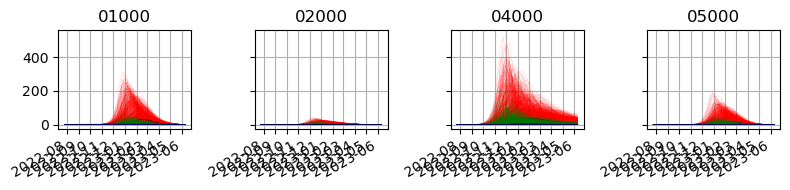

In [ ]:
grid = (1,4)
fig, axes = plt.subplots(grid[0], grid[1], sharex=True, sharey=True, figsize=(grid[1]*2,grid[0]*2))
for i, ax in enumerate(axes.flat):
    c = ['red', 'green', 'blue']
    place = full_xarr.get_index('place')[i]
    tp = full_xarr.sel(place=place)
    for k, val in enumerate(full_xarr.feature):
        ax.plot(tp.date, tp.sel(feature=val).T, c = c[k], lw = .1, alpha=.5)
        ax.plot(tp.date, tp.sel(feature=val).T.median(axis=1), 
                c = 'k',#'dark'+c[k], 
                lw = .5, 
                alpha=1)
    ax.grid()
    ax.set_title(place)
fig.autofmt_xdate()
fig.tight_layout()

In [ ]:
full_xarr_w = full_xarr.resample(date="W").sum()
full_xarr_w

In [ ]:
full_xarr_w_padded = full_xarr_w.pad({'date': (0, 17), 'place':(0,13)}, mode='constant', constant_values=0)
print(full_xarr_w_padded.shape)
full_xarr_w_padded.to_netcdf("datasets/synthetic/CSP_FluSMHR1_weekly_padded_4scn.nc")

## Dengue Trial

```python
def yw2date(row):
    year = int(row["year"])
    week = int(row["week"])
    date = "{}-{}-1".format(year, week)
    return datetime.strptime(date, "%Y-%W-%w")
df = pd.read_csv('dengue-thailand-province-week.csv')
df['year'] = df['date_sick_year']
df = df.drop('date_sick_year', axis=1)
df['date'] = df.apply(yw2date, axis=1)

## Cannot pivot there are duplicated entries:
df1 = df.set_index(['year', 'week', 'province'])
duplicated = np.where(df1.index.duplicated())
print(len(duplicated[0]), "duplicated index entries...")
print(duplicated[0])
print(df1.iloc[116065])
print(df1.loc[1999, 1, 10])

# pivot_table with aggregrate as mean
df = df.pivot_table(index='date', columns='province', values='cases', aggfunc='mean') # perhaps should be sum
fig, axes = plt.subplots(11, 7, sharex=True, sharey=True, figsize=(10,10))
for i, prov in enumerate(df.columns):
    ax = axes.flat[i]
    ax.plot(df[prov])
    ax.grid()
    ax.set_title(prov)
fig.autofmt_xdate()
fig.tight_layout()
```